# Introduction

My friend [Johannes Giorgis] and I are developing a series of [Data Science Challenges] to help others
become better data scientists by presenting a series of challenges.  Why did we do this?


> Because that's what heroes do!
>
> --Johannes Giorgis

I now present my response to the first challenge, Exploring the Meetup API in my the city of my choice.

**San Francisco, CA**, I choose you!



# Challenge 01: Explore the Meetup API
Use the [Meetup API] to explore meetups in your city of choice.


**Guide Questions**:

Below are some guide line questions to get you started:

- What is the largest meetup in your location of choice (city, cities, country...etc)?
- How many meetups of a certain category (e.g. Tech, Art...etc) are in your city?
- Basic statistics of meetups
	- What is the average size of meetups?
	- How frequently do meetups host events?




## Prerequisites:
Add a [Meetup API Key] to your environment.

[//]: # (References)

[Meetup API]: https://www.meetup.com/meetup_api/
[Meetup API Key]: https://secure.meetup.com/meetup_api/key/
[Johannes Giorgis]: http://johannesgiorgis.com/
[Data Science Challenges]: https://medium.com/red-panda-ai/introducing-data-science-challenges-4ae4a103d67b

In [1]:
import datetime
import json
import math
import meetup.api
import os
import pprint
import requests

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

from tqdm import tnrange, tqdm_notebook

%matplotlib inline

## Double check your environment

Nothing works without **MEETUP_API_KEY**.

In [2]:
assert 'MEETUP_API_KEY' in os.environ, (
    "You need a MEETUP_API_KEY in your environment please look at the "
    "README for instructions.")
client = meetup.api.Client()

## Categories

There are multiple categories of groups in Meetup, let's use Python's meetup.api to [GetCategories](https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetCategories).

In [3]:
%%capture --no-display
categories = client.GetCategories()

### Exploring the response object

By looking at the **meta** member of the response, we can see that there are 33 different categories.

### What are the attributes of the response object?
We can find out by using __dict__ to get the attribute dictionary.  First, 
let's create some helper functions

In [4]:
# Helper functions
def parse_meta(response):
    """Return a vertically aligned dataframe, where each row is an element 
    of the response.meta dictionary"""
    return pd.DataFrame.from_dict(response.meta, orient='index')

def parse_results(response):
    """Return a horizontally aligned dataframe, where each column is an
    element of the response.results dictionary """
    return pd.DataFrame.from_dict(response.results)


### Now we can easily inspect our categories response object

#### Firstly, let's look at the meta-data

In [5]:
cat_meta_df = parse_meta(categories)
cat_meta_df

,0
next,
method,Categories
total_count,33
link,https://api.meetup.com/2/categories
count,33
description,Returns a list of Meetup group categories
lon,None
title,Categories
url,https://api.meetup.com/2/categories?offset=0&f...
id,


We can see from the meta that there are 33 categories available to us.
I wonder what they are.  

Also, notice that the value of **next** (above) is an empty string.  Meetup API v2 response payloads come in **pages**, one at a time, but provide the URI of the **next** API call in the sequence.  We can use this to programmatically get each next **page** in **response.meta\["next"\]**. until the complete result is returned.

As we can see, the **response.meta\["next"\]** for this page is an empty string, so all of the categories
fit into our first API call.

#### Secondly, let's review the categories themselves

In [6]:
cats_df = parse_results(categories)
cats_df

,id,name,shortname,sort_name
0,1,Arts & Culture,Arts,Arts & Culture
1,18,Book Clubs,Book Clubs,Book Clubs
2,2,Career & Business,Business,Career & Business
3,3,Cars & Motorcycles,Auto,Cars & Motorcycles
4,4,Community & Environment,Community,Community & Environment
5,5,Dancing,Dancing,Dancing
6,6,Education & Learning,Education,Education & Learning
7,8,Fashion & Beauty,Fashion,Fashion & Beauty
8,9,Fitness,Fitness,Fitness
9,10,Food & Drink,Food & Drink,Food & Drink


### So, if we want to work with a particular category
In this case, I want **Tech**. Let's query the dataframe for categories named **Tech**.

In [7]:
tech_df = cats_df.loc[cats_df['name'] == 'Tech']
tech_df

,id,name,shortname,sort_name
31,34,Tech,Tech,Tech


### Let's store the category ID number for later use

In [8]:
tech_category_id = tech_df['id'].values[0]
tech_category_id

34

## Explore Cities
### Now let's look at cities in the United States named San Francisco

In [9]:
%%capture --no-display
cities_resp = client.GetCities(country='United States', query='San Francisco')

Here we used the [GetCities] method of the [Python Meetup API client]

I used a query for cities in **United States** called **San Francisco**.

[//]: # (References)

[GetCities]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetCities
[Python Meetup API client]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#api-client-details

Now let's take a look at the **meta** for our results.

In [10]:
cities_meta_df = parse_meta(cities_resp)
cities_meta_df

,0
next,
method,Cities
total_count,10
link,https://api.meetup.com/2/cities
count,10
description,Returns Meetup cities. This method supports se...
lon,None
title,Cities
url,https://api.meetup.com/2/cities?offset=0&query...
id,


### Hmm, a count of 10 cities is suspicious...

I only know of the one San Francisco, why are there 10 cities?

In [11]:
cities_df = parse_results(cities_resp)
cities_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,San Francisco,us,94101,37.779999,USA,-122.419998,60351,"San Francisco, California, USA",0,CA,94101
1,Bosque,us,87006,34.560001,USA,-106.779999,5,"San Francisco, New Mexico, USA",1,NM,87006
2,San Luis,us,81152,37.080002,USA,-105.620003,4,"San Francisco, Colorado, USA",2,CO,81152
3,San Francisco de Macorís,do,1009671,19.299999,Dominican Republic,-70.250000,4,"San Francisco de Macorís, Dominican Republic",3,NaN,meetup6
4,Reserve,us,87830,33.650002,USA,-108.769997,1,"San Francisco Plaza, New Mexico, USA",4,NM,87830
5,San Francisco de Yojoa,hn,1016115,15.020000,Honduras,-87.970001,1,"San Francisco de Yojoa, Honduras",5,NaN,meetup213
6,San Francisco del Mar,mx,1028671,16.230000,Mexico,-94.650002,1,"San Francisco del Mar, Mexico",6,NaN,meetup1676
7,San Francisco Menéndez,sv,1038344,13.850000,El Salvador,-90.019997,0,"San Francisco Menéndez, El Salvador",7,NaN,meetup110
8,San Francisco,ar,1111239,-31.430000,Argentina,-62.080002,0,"San Francisco, Argentina",8,NaN,meetup95
9,San Francisco El Alto,gt,1015524,14.950000,Guatemala,-91.449997,0,"San Francisco El Alto, Guatemala",9,NaN,meetup24


### Let's filter the dataframe with a query give us only cities in California, US

In [12]:
single_city_df = cities_df.loc[
    (cities_df['state'] == 'CA') & 
    (cities_df['country'] == 'us')]

single_city_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,San Francisco,us,94101,37.779999,USA,-122.419998,60351,"San Francisco, California, USA",0,CA,94101


One San Francisco, perfect!  

### Let's store the latitude and longitude for later use as well

In [13]:
latitude = single_city_df['lat'].values[0]
longitude = single_city_df['lon'].values[0]
latitude, longitude

(37.779998779296875, -122.41999816894531)

## Now let's look at groups in San Francisco, CA

### Since we are going to grab lots of groups, lets make a function to help us call the API

Note, this function will use the tech_category_id, latitude, and longitude values that we 
found eariler.

In [14]:
def get_a_group(page_number, category_id=tech_category_id, lat=latitude,
               lon=longitude):
    group = None
    retry_counter, retry_max = 0, 3
    print(f"Getting page {page_number}")
    while retry_counter < retry_max:
        try:
            group = client.GetGroups(
            category_id=category_id, lat=lat, lon=lon, offset=page_number)
            return group
        except:
            print(f"Fetch failure {retry_counter + 1}")
            retry_counter += 1

    raise Exception(f"Unable to fetch page after {retry_counter} attempts")



### Now, After grabbing the first group

Let's review the **meta** to help us see what we are getting into

In [15]:
%%capture --no-display
group_resp = get_a_group(0)
group_meta = parse_meta(group_resp)
group_meta

,0
next,https://api.meetup.com/2/groups?offset=1&forma...
method,Groups
total_count,2186
link,https://api.meetup.com/2/groups
count,200
description,None
lon,-122.42
title,Meetup Groups v2
url,https://api.meetup.com/2/groups?offset=0&forma...
id,


### Wait! There's a meta[\"next\"].

Remember earlier when I spoke about **response.meta\["next"\]**?  

I seems as though our result will span mulitple API calls, each returning 200 new groups.

Let's make a new helper that will grab each payload in a series of API calls until we obtain the entire data set:

In [16]:
def get_all_groups_as_a_df():
    """Returns a single dataframe composed from data from multiple
    successive calls to get_a_group.
    
    We will loop through get_a_group pages while our page.meta['next'] is 
    not the empty string.
    """
    page_df_list = []
    next_page = None
    page_number = 0
    while next_page != '':  
        page = get_a_group(page_number)
        next_page = page.meta["next"]
        frame = parse_results(page)
        page_number += 1
        page_df_list.append(frame)
        
    return pd.concat(page_df_list, ignore_index=True)



In [17]:
# Collect all groups into a single dataframe
all_groups_df = get_all_groups_as_a_df()

# Show the first row in the dataframe
all_groups_df.head(1)

Getting page 0
29/30 (10 seconds remaining)
Getting page 1
28/30 (8 seconds remaining)
Getting page 2
27/30 (8 seconds remaining)
Getting page 3
26/30 (6 seconds remaining)
Getting page 4
25/30 (5 seconds remaining)
Getting page 5
24/30 (4 seconds remaining)
Getting page 6
23/30 (3 seconds remaining)
Getting page 7
22/30 (1 seconds remaining)
Getting page 8
21/30 (0 seconds remaining)
Getting page 9
29/30 (10 seconds remaining)
Getting page 10
28/30 (9 seconds remaining)


,category,city,country,created,description,group_photo,id,join_mode,lat,link,...,name,organizer,rating,state,timezone,topics,urlname,utc_offset,visibility,who
0,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",San Francisco,US,1034097740000,<p>The SF PHP Community Meetup is an open foru...,{'highres_link': 'https://secure.meetupstatic....,120903,open,37.77,https://www.meetup.com/sf-php/,...,SF PHP Community,"{'member_id': 126468982, 'name': 'Andre Marigo...",4.38,CA,US/Pacific,"[{'urlkey': 'php', 'name': 'PHP', 'id': 455}, ...",sf-php,-28800000,public,PHP Developers


### That's too many columns
I really only care about a small list of columns, let's exclude the unneeded columns.

In [18]:
column_list = ['id', 'name', 'members', 'rating', 'join_mode', 'urlname']
all_groups_df = all_groups_df[column_list]
all_groups_df.head(1)

,id,name,members,rating,join_mode,urlname
0,120903,SF PHP Community,2696,4.38,open,sf-php


### Let's double check the size of our new dataframe

In [19]:
all_groups_df.shape

(2186, 6)

That looks just about right:
* 2186 rows
* 6 columns

---
## Explore Members per Group

Each group has a different sized membership, let's explore this first!


### Let's start with with a histogram

This visualization should give us a basic idea of how big our groups are.

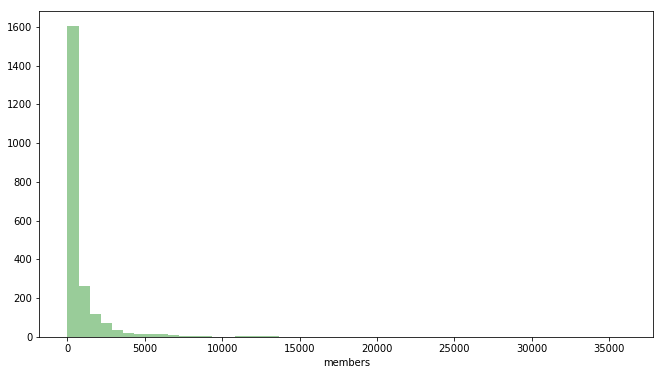

In [20]:
# Using seaborn's distplot function
plt.rcParams['figure.figsize'] = [11, 6]
sb.distplot(all_groups_df['members'], kde=False, color="g");

### It appears that most groups are relatively small

Let's take a closer look at some basic stats for our data in a tabular 
format for some hard numbers:

In [21]:
pd.options.display.float_format = '{:20,.2f}'.format
all_groups_df[["members", "rating"]].describe()

,members,rating
count,"2,186.00","2,186.00"
mean,814.32,2.75
std,"1,743.11",2.34
min,1.00,0.00
25%,87.25,0.00
50%,257.00,4.48
75%,781.75,4.84
max,"36,050.00",5.00


As a table I can see some numbers:

1.  It looks like the average group size is about 814 persons.
2.  Half of the group sits at or under 257 members.
3.  The smallest group has a single person.
4.  **the largest group has 36,000+ members!**

What an outlier!  But are there other **mega-groups** like this?

### Maybe a box and whisker plot can visualize these stats for us

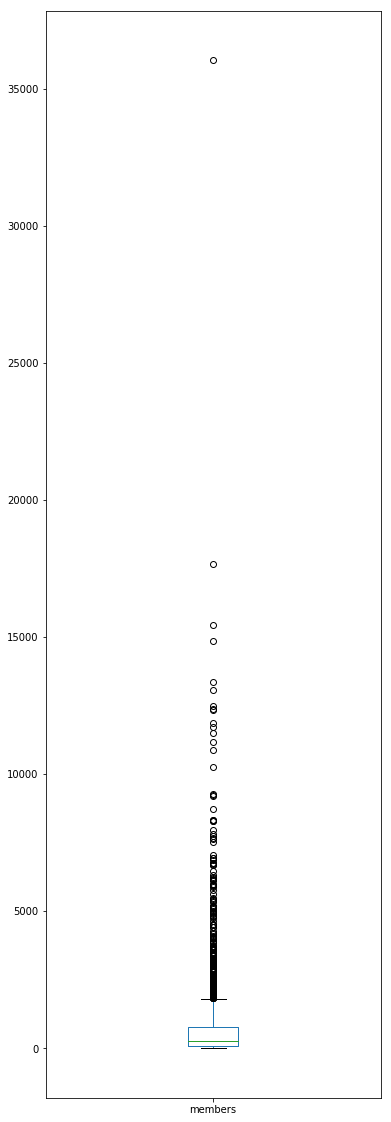

In [22]:
plt.rcParams['figure.figsize'] = [6, 20]

#sb.set(style="whitegrid")
#ax = sb.boxplot(y="members", data=all_groups_df, palette="Set2")
all_groups_df['members'].plot.box();

Wow, there are quite a few **mega-groups**, as indicated by the circles above our top whisker!

---

Why are the groups so big?

In fact...

### What are the 10 biggest tech groups in the area?

In [23]:
biggest_ten_df = all_groups_df.sort_values('members', ascending=False).head(10)
biggest_ten_df

,id,name,members,rating,join_mode,urlname
19,844726,Silicon Valley Entrepreneurs & Startups,36050,4.58,open,sventrepreneurs
107,1619955,SFHTML5,17656,4.67,open,sfhtml5
106,1615633,Designers + Geeks,15433,4.46,open,designersgeeks
426,9226282,SF Data Science,14864,4.49,open,SF-Data-Science
28,1060260,The SF JavaScript Meetup,13354,4.54,open,jsmeetup
250,3483762,Tech in Motion Events: San Francisco,13073,4.48,approval,TechinMotionSF
540,13402242,Docker Online Meetup,12471,4.37,open,Docker-Online-Meetup
191,2065031,SF Data Mining,12378,4.64,open,Data-Mining
201,2252591,Women Who Code SF,12326,4.78,open,Women-Who-Code-SF
705,18354966,SF Big Analytics,11858,4.53,open,SF-Big-Analytics


## Get Group Events

### We need to do some data shaping before the next api call

Mostly we need to:
1.  pass in a string with group ids from our 10 biggest groups
2.  convert our human-readable date ranges to milliseconds since Jan 1, 1970
3.  Call the GetEvents API filtering for past events using our group IDs and our date range

#### First, let's make that string of group ids


In [24]:
id_list = biggest_ten_df['id'].tolist()
id_list
ids = ','.join(str(x) for x in id_list)
ids

'844726,1619955,1615633,9226282,1060260,3483762,13402242,2065031,2252591,18354966'

#### Now, let's get the epoch milliseconds for a date range between now and 9 months ago

In [25]:
def to_millis(dt):
    return int(pd.to_datetime(dt).value / 1000000)

right_now = to_millis(datetime.datetime.now())
nine_months_ago = int(right_now - 180 * 24 * 60 * 60 * 1000)
print(f"Now: {right_now}, nine months ago: {nine_months_ago}")

Now: 1550586521274, nine months ago: 1535034521274


#### Finally, let's look at those events.

In [26]:
%%capture --no-display
events_resp = client.GetEvents(group_id=ids, status='past',
                               time=f"{nine_months_ago},{right_now}");

In [27]:
parse_meta(events_resp)

,0
next,
method,Events
total_count,106
link,https://api.meetup.com/2/events
count,106
description,"Access Meetup events using a group, member, or..."
lon,
title,Meetup Events v2
url,https://api.meetup.com/2/events?offset=0&forma...
id,


### Again, our raw results dataframe has extra columns that I don't care about

In [28]:
raw_results_df = parse_results(events_resp)
raw_results_df.head(1)

,created,description,duration,event_url,group,headcount,how_to_find_us,id,maybe_rsvp_count,name,...,rating,rsvp_limit,status,time,updated,utc_offset,venue,visibility,waitlist_count,yes_rsvp_count
0,1531451567000,"<p>We are going to have two talks, one from Go...",10800000,https://www.meetup.com/SF-Big-Analytics/events...,"{'join_mode': 'open', 'created': 1421705588000...",0,NaN,252731150,0,TensorFlow Probability and how Yelp use ML to ...,...,"{'count': 0, 'average': 0}",nan,past,1535072400000,1535085901000,-25200000,"{'zip': '94105', 'country': 'us', 'localized_c...",public,0,646


### So again, let's filter down to just what's relevant

In [29]:
raw_results_df = parse_results(events_resp)
column_list = ['group', 'time', 'duration', 'yes_rsvp_count']
raw_results_df = raw_results_df[column_list]
raw_results_df.head(1)

,group,time,duration,yes_rsvp_count
0,"{'join_mode': 'open', 'created': 1421705588000...",1535072400000,10800000,646


### The group column

The **group** column is actually a JSON object full of metadata about the group.

I really only need the **group\["id"\]** for now, so let's focus on that.

In [30]:
def get_id(my_dict):
    """Extract the id member of a python dictionary"""
    return my_dict["id"]

raw_results_df["id"] = raw_results_df["group"].apply(get_id)

# Let's 
columns = ['id', 'time', 'duration', 'yes_rsvp_count']
raw_results_df = raw_results_df[columns]
raw_results_df.head(1)

,id,time,duration,yes_rsvp_count
0,18354966,1535072400000,10800000,646


### Next, let's it seems that our time fields is in epoch milliseconds

The **time** is stored in **Epoch milliseconds** format.

This is great if you want to see time as the number of milliseconds since Jan 1, 1970.

This is not-so-great if you just want to see a human-readable date and time equivalent

Let's make a new human-readable column called **time_dt**

In [31]:
for field in ["time"]:
    raw_results_df["time_dt"] = pd.to_datetime(
        raw_results_df[field], unit='ms').dt.strftime('%m/%d/%y %H:%M')
    
    #raw_results_df["time_dt"] = raw_results_df["time_dt"].strftime('%m/%d/%y')
    
columns = ['id', 'time','time_dt', 'duration', 'yes_rsvp_count']
raw_results_df = raw_results_df[columns]
raw_results_df.head(1)

,id,time,time_dt,duration,yes_rsvp_count
0,18354966,1535072400000,08/24/18 01:00,10800000,646


### Now let's convert the duration column to something human-readble

Let's convert the column to a string that shows hours and minutes.

In [32]:
def millis_2_hours_and_minutes(ms):
    """Converts milliseconds to hours and minutes."""
    seconds = ms / 1000
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)

    return f"{int(hours)} hours, {int(minutes)} minutes" 

raw_results_df["duration"] = raw_results_df["duration"].apply(
    millis_2_hours_and_minutes)

raw_results_df.head(1)

,id,time,time_dt,duration,yes_rsvp_count
0,18354966,1535072400000,08/24/18 01:00,"3 hours, 0 minutes",646


## Now let's join our top ten mega-groups dataframe with our events dataframe

If you are familiar with SQL this is similar to a left join from **raw_results_df**
to **biggest_ten_df** on **id**

Then we sort the output by **name** ascending and then **time** descending.

In [33]:
# lets merge in the group names

merged_df = pd.merge(
    raw_results_df,
    biggest_ten_df[['id', 'name']],
    on='id',
    how='left')

columns = ['name', 'time', 'time_dt', 'duration', 'yes_rsvp_count']
final_df = merged_df[columns]

# And then sort the output by name and time
final_df.sort_values(by=['name', 'time'], ascending=[True, False])

,name,time,time_dt,duration,yes_rsvp_count
60,Designers + Geeks,1542337200000,11/16/18 03:00,"2 hours, 0 minutes",71
51,Designers + Geeks,1541124000000,11/02/18 02:00,"2 hours, 0 minutes",71
37,Designers + Geeks,1539914400000,10/19/18 02:00,"2 hours, 0 minutes",41
29,Designers + Geeks,1538704800000,10/05/18 02:00,"2 hours, 0 minutes",29
19,Designers + Geeks,1537495200000,09/21/18 02:00,"2 hours, 0 minutes",37
9,Designers + Geeks,1536285600000,09/07/18 02:00,"2 hours, 0 minutes",87
45,Docker Online Meetup,1540915200000,10/30/18 16:00,"1 hours, 0 minutes",1
102,SF Big Analytics,1549591200000,02/08/19 02:00,"2 hours, 30 minutes",418
85,SF Big Analytics,1547690400000,01/17/19 02:00,"3 hours, 0 minutes",450
83,SF Big Analytics,1547604000000,01/16/19 02:00,"3 hours, 0 minutes",5


### Ah, this is interesting

From the top 10 mega-groups I can see that **SF Data Science** meets pretty regularly, and that their attendance is pretty consistent.  

Let's take a closer look at just this group by using another dataframe query.

In [34]:
interesting_group_df = final_df[final_df['name'] == "SF Data Science"]
interesting_group_df

,name,time,time_dt,duration,yes_rsvp_count
31,SF Data Science,1539306000000,10/12/18 01:00,"3 hours, 0 minutes",15
35,SF Data Science,1539910800000,10/19/18 01:00,"2 hours, 0 minutes",95
43,SF Data Science,1540774800000,10/29/18 01:00,"4 hours, 0 minutes",21
57,SF Data Science,1542211200000,11/14/18 16:00,"10 hours, 0 minutes",1
65,SF Data Science,1543539600000,11/30/18 01:00,"3 hours, 30 minutes",18
86,SF Data Science,1547692200000,01/17/19 02:30,"2 hours, 0 minutes",59
87,SF Data Science,1547778600000,01/18/19 02:30,"2 hours, 0 minutes",26
94,SF Data Science,1548383400000,01/25/19 02:30,"2 hours, 0 minutes",48
98,SF Data Science,1548988200000,02/01/19 02:30,"2 hours, 0 minutes",94


### A simple bar chart shows us something

I will use the **time_dt** column vs **yes_rsvp_count** to see if people
are looking forward to new events.

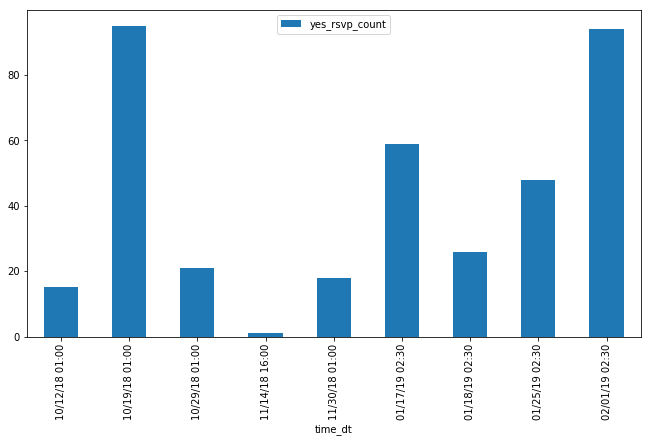

In [35]:
plt.rcParams['figure.figsize'] = [11, 6]

lines = interesting_group_df[['yes_rsvp_count', 'time_dt']].plot(
    kind='bar', x='time_dt', y='yes_rsvp_count', style='.-')

---

This is nice, but what is the trend, is the group active?  It's tough to tell
from a simple bar chart.

### Let's visualize the trend line

Let's see the trend using a seaborn regplot.  

I'll use the epoch milliseconds **time** column of our dataframe, since it is numeric and can be used to generate a trend line.

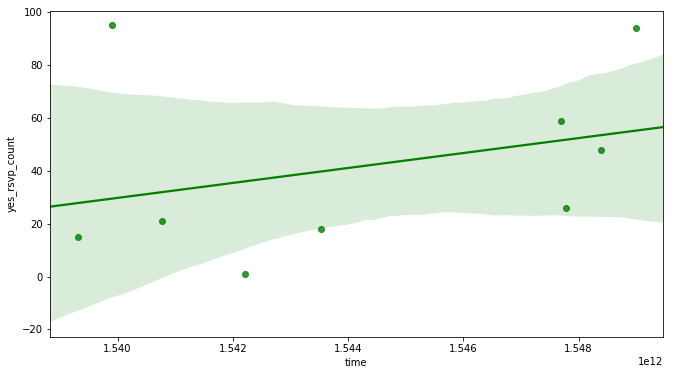

In [36]:
sb.regplot(x='time', y='yes_rsvp_count', data=interesting_group_df,
           color="green")

## Goal Achieved!

At last!  We found a Tech group in San Francisco, CA that:
1.  is among the 10 biggest in the city
2.  has a trend of more and more people RSVP-ing to their events
3.  holds events occuring every few weeks.

## Conclusion

We achieved our objectives and found the largest tech meetup in San Francisco
To do this, we :
1.  worked with the [Python Meetup API client]
2.  built helper functions to deal with our response objects' **meta** and **results** dictionaries
3.  loaded pages of **results** from multiple API calls into Pandas dataframes
4.  Used [pandas.DataFrame.query] to filter and data of interest
5.  Used [pandas.DataFrame.apply] to clean columns of data using custom helper functions
5.  Used [pandas.DataFrame.describe] to get descriptive statistics that summarize
    * the central tendency
    * dispersion
    * shape of our dataset's distribution
6.  Merged the **events** and **groups** dataframes to create a report of the events for our 10
    biggest mega-groups in technology
7.  Found a mega-group that shows enduring and increasing interest by its membership


[//]: # (References)

[Python Meetup API client]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#api-client-details
[pandas.DataFrame.query]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html
[pandas.DataFrame.apply]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
[pandas.DataFrame.describe]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html